# Predicting Loan Status: EDA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists

import helpers as hp
from config import usr, pwd, url, port, db, table

%matplotlib inline

## Load Dataset

In [2]:
# Load dataset from web
# df = pd.read_csv(
#     'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
#     skipinitialspace=True,
#     header=1
# )

In [3]:
# Save dataset locally
# df.to_csv('./data/LoanStats3d.csv')

In [4]:
# Load dataset locally
df = pd.read_csv('./data/LoanStats3d.csv', index_col=0)

/Users/dave/anaconda3/envs/py_36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (1,20,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(f'There are {len(df)} rows in the raw dataset.')
print(f'There are {len(df.columns)} columns in the raw dataset.')

There are 421097 rows in the raw dataset.
There are 111 columns in the raw dataset.


## Data Cleaning
Save raw `DataFrame` to a new `DataFrame`.

In [6]:
df_clean = df.copy()

Remove any rows that are completely empty.

In [7]:
df_clean.dropna(thresh=2, inplace=True)

In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421095 entries, 0 to 421094
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(85), object(26)
memory usage: 359.8+ MB


Drop id since it is useless anyways

In [9]:
df_clean.drop(['id'], axis=1, inplace=True)

Convert interest rate column to numerical values.

In [10]:
df_clean['int_rate'] = pd.to_numeric(df_clean['int_rate'].str.strip('%'), errors='coerce')

Count continous and categorical variables. Save each type of variable to a list.

In [11]:
cont_variables, cat_variables = hp.find_variable_types(df_clean)
print(f'There are {len(cont_variables)} continous variables.')
print(f'There are {len(cat_variables)} categorical variables.')

There are 86 continous variables.
There are 24 categorical variables.


In [12]:
cont_variables

['member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo

In [13]:
cat_variables

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'verification_status_joint']

Split dataset into categorical and continous variables.

In [14]:
df_categorical = df_clean.loc[:, cat_variables].copy()
df_continous = df_clean.loc[:, cont_variables].copy()

### Categorical Variables
Remove categorical variables with high category counts.

In [15]:
df_cat_counts = hp.find_category_counts(df_categorical, cat_variables)

In [16]:
df_cat_counts

,category,count
0,url,421095
1,emp_title,120813
2,revol_util,1212
3,zip_code,914
4,earliest_cr_line,668
5,addr_state,49
6,desc,35
7,sub_grade,35
8,title,28
9,last_credit_pull_d,27


In [17]:
hp.remove_high_category_counts(df_categorical, cat_variables, thresh=30)

8 categorical variables with at least 30 categories will be removed.
The dataset went from 24 to 16 columns.


### Continous variables
#### Missing Values
Inspect missing values for the continous variables and decide how to handle them.

In [18]:
hp.find_na_columns(df_continous, display_fractions=True)

Variables with missing values and their fraction of missing values:
mths_since_last_delinq            0.484361
mths_since_last_record            0.823282
mths_since_last_major_derog       0.708548
annual_inc_joint                  0.998786
dti_joint                         0.998791
open_acc_6m                       0.949247
open_il_6m                        0.949247
open_il_12m                       0.949247
open_il_24m                       0.949247
mths_since_rcnt_il                0.950581
total_bal_il                      0.949247
il_util                           0.955789
open_rv_12m                       0.949247
open_rv_24m                       0.949247
max_bal_bc                        0.949247
all_util                          0.949247
inq_fi                            0.949247
total_cu_tl                       0.949247
inq_last_12m                      0.949247
bc_open_to_buy                    0.009411
bc_util                           0.010038
mo_sin_old_il_acct           

In [19]:
na_fractions = hp.find_na_columns(df_continous)

In [20]:
na_fractions.sort_values()

num_rev_accts                     0.000002
mths_since_recent_bc              0.009019
bc_open_to_buy                    0.009411
bc_util                           0.010038
percent_bc_gt_75                  0.010067
mo_sin_old_il_acct                0.029100
num_tl_120dpd_2m                  0.045667
mths_since_recent_inq             0.105912
mths_since_last_delinq            0.484361
mths_since_recent_revol_delinq    0.639661
mths_since_last_major_derog       0.708548
mths_since_recent_bc_dlq          0.742101
mths_since_last_record            0.823282
inq_last_12m                      0.949247
open_acc_6m                       0.949247
open_il_6m                        0.949247
open_il_24m                       0.949247
max_bal_bc                        0.949247
inq_fi                            0.949247
all_util                          0.949247
open_il_12m                       0.949247
open_rv_24m                       0.949247
open_rv_12m                       0.949247
total_bal_i

In [21]:
print(len(na_fractions))
print(len(df_continous.columns))

29
86


Remove continous variables that contain mostly missing values. I will chose a cutoff of 40%. If more than 40% of the values (or a fraction of 0.4) are missing I will remove those values.

In [22]:
# features_to_drop = na_fractions[na_fractions < 0.4].index.tolist()
# print(features_to_drop)
# df_continous.drop(features_to_drop, axis=1, inplace=True)

Remove continous variables that contain any missing values.

In [23]:
df_continous.drop(na_fractions.index.tolist(), axis=1, inplace=True)

For the remaining columns with missing values, I will fill the missing values with zeros.

In [24]:
df_continous.fillna(0, inplace=True)

## Data Exploration and Feature Engineering
### Categorical variables
Use a $\chi$<sup>2</sup> technique to decide which categorical features have the most predictive power with _loan\__status_.

In [25]:
df_categorical.columns.tolist()

['term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'title',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'verification_status_joint']

In [26]:
categorical_features = df_categorical.columns.tolist()
categorical_features.remove('loan_status')

In [27]:
cat_list = hp.select_cat_variables(df_categorical, 'loan_status', categorical_features, alpha=0.05)

Feature Chi-squared Statistics: (p-value < 0.05)
* term: chi2 = 3564.653, p-value = 0.000e+00, dof = 6
* grade: chi2 = 20736.899, p-value = 0.000e+00, dof = 36
* emp_length: chi2 = 321.546, p-value = 1.979e-37, dof = 60
* home_ownership: chi2 = 1675.994, p-value = 0.000e+00, dof = 18
* verification_status: chi2 = 2499.586, p-value = 0.000e+00, dof = 12
* issue_d: chi2 = 11328.850, p-value = 0.000e+00, dof = 66
* purpose: chi2 = 2523.914, p-value = 0.000e+00, dof = 78
* title: chi2 = 2576.824, p-value = 0.000e+00, dof = 156
* initial_list_status: chi2 = 2475.066, p-value = 0.000e+00, dof = 6
* last_pymnt_d: chi2 = 544592.431, p-value = 0.000e+00, dof = 144
* next_pymnt_d: chi2 = 1346.930, p-value = 3.832e-281, dof = 12
* last_credit_pull_d: chi2 = 248802.554, p-value = 0.000e+00, dof = 150
* application_type: chi2 = 25.138, p-value = 3.219e-04, dof = 6
3 categorical features will be removed.


In [28]:
df_categorical = df_categorical.loc[:, cat_list].copy()

#### Dummy variable
Convert categorical features into dummy variables.

In [29]:
df_categorical = pd.get_dummies(df_categorical).copy()

#### Missing Values
Find out how many missing values there are in the categorical dataset.

In [30]:
hp.find_na_columns(df_categorical, display_fractions=True)

Variables with missing values and their fraction of missing values:
Series([], dtype: float64)


There are no missing values for categorical variables.

### Continous variables
Compare continous features and remove those that are highly correlated with eachother.

In [31]:
df_corr = df_continous.corr()

In [32]:
df_corr

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
member_id,1.000000,-0.008620,-0.008620,-0.008885,-0.053447,-0.013274,0.014958,0.005806,0.002261,0.000715,...,-0.000406,-0.000700,0.008723,-0.010437,0.004625,-0.000908,0.015297,0.012688,0.017822,0.020684
loan_amnt,-0.008620,1.000000,1.000000,0.999994,0.140572,0.941205,0.305734,0.006103,-0.010424,-0.039040,...,0.002461,-0.031334,-0.042158,0.105056,-0.124430,0.002087,0.347289,0.289565,0.395843,0.203093
funded_amnt,-0.008620,1.000000,1.000000,0.999994,0.140572,0.941205,0.305734,0.006103,-0.010424,-0.039040,...,0.002461,-0.031334,-0.042158,0.105056,-0.124430,0.002087,0.347289,0.289565,0.395843,0.203093
funded_amnt_inv,-0.008885,0.999994,0.999994,1.000000,0.140209,0.941187,0.305803,0.006044,-0.010448,-0.039103,...,0.002448,-0.031349,-0.042263,0.105096,-0.124394,0.002070,0.347355,0.289554,0.395973,0.203085
int_rate,-0.053447,0.140572,0.140572,0.140209,1.000000,0.124426,-0.090399,0.077932,0.043710,0.231139,...,0.021897,0.031344,0.256831,-0.061652,0.065078,0.012234,-0.121081,-0.000676,-0.257222,0.004055
installment,-0.013274,0.941205,0.941205,0.941187,0.124426,1.000000,0.297393,0.001893,-0.002129,-0.006255,...,0.005279,-0.024302,-0.010656,0.085217,-0.112663,0.010279,0.315373,0.265224,0.358718,0.181215
annual_inc,0.014958,0.305734,0.305734,0.305803,-0.090399,0.297393,1.000000,-0.068237,0.037910,0.022990,...,0.011602,0.005709,0.045330,-0.005866,-0.050312,0.038323,0.391129,0.297563,0.257184,0.242637
dti,0.005806,0.006103,0.006103,0.006044,0.077932,0.001893,-0.068237,1.000000,-0.005868,0.003277,...,0.002671,-0.005476,0.031698,0.042020,-0.015054,-0.014954,-0.000674,0.100831,0.012969,0.113685
delinq_2yrs,0.002261,-0.010424,-0.010424,-0.010448,0.043710,-0.002129,0.037910,-0.005868,1.000000,0.036139,...,0.111401,0.649762,-0.017943,-0.451422,-0.040508,0.011366,0.059349,0.026929,-0.081793,0.061466
inq_last_6mths,0.000715,-0.039040,-0.039040,-0.039103,0.231139,-0.006255,0.022990,0.003277,0.036139,1.000000,...,-0.004539,0.049446,0.370187,-0.058290,0.120260,0.018906,0.009545,0.029615,-0.012923,0.039506


In [33]:
df_continous['policy_code'].unique()

array([1.])

There are only NaN values for correlations with _policy\__code_. This is because there is only one value for this variable. I will drop it.

In [34]:
df_continous.drop(['policy_code'], axis=1, inplace=True)

Remove highly correlated features.

In [35]:
df_corr_abs = df_continous.corr().abs()

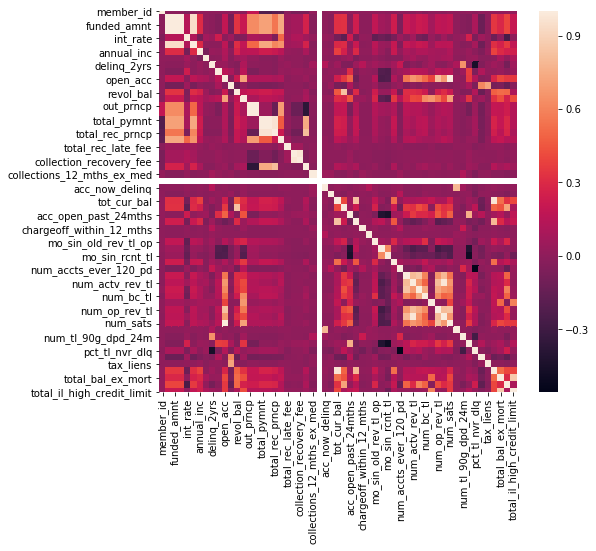

In [36]:
f, axes = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(df_corr, ax=axes)
plt.show()

In [37]:
upper_triangle = df_corr_abs.where(np.triu(np.ones(df_corr_abs.shape), k=1).astype(np.bool))

In [38]:
thresh = 0.6
correlated_columns = [column for column in upper_triangle.columns if any(upper_triangle[column] > thresh)]

In [39]:
df_continous.drop(correlated_columns, axis=1, inplace=True)
df_corr = df_continous.corr()

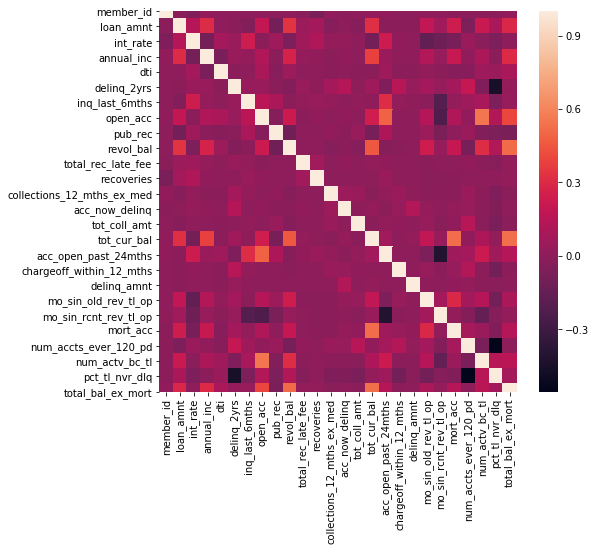

In [40]:
f, axes = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(df_corr, ax=axes)
plt.show()

### Combine datasets
Combine continuous and categorical datasets.

In [41]:
df_cleaned = pd.concat([df_continous, df_categorical], axis=1) 

In [42]:
df_cleaned['loan_status'] = df_clean['loan_status']

Replace parentheses with empty characters so that dataset can be imported into SQL database successfully.

In [43]:
old_columns = df_cleaned.columns.tolist()
new_columns = [x.replace('(', '') for x in old_columns]
new_columns = [x.replace(')', '') for x in new_columns]
df_cleaned.columns = new_columns

## Save Dataset
Save cleaned dataset to a SQL database.

In [44]:
# Create the database if it doesn't exist
db_url = f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}"
if database_exists(db_url):
    pass
else:
    create_database(db_url)

In [45]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [46]:
df_cleaned.to_sql(name=table, con=engine, index=False, if_exists='replace')

In [47]:
engine.dispose()